#### Imports

In [1]:
import sys
import os
import os.path

import numpy as np
import skimage.io
import glob

import shutil
from config import config_vars
import pathlib


from tqdm import tqdm

import matplotlib.pyplot as plt
import skimage.morphology

#import tensorflow as tf
#import keras

#import utils.metrics
#import utils.model_builder
from skimage.transform import resize

In [2]:
from skimage import measure
from skimage import filters

In [3]:
from skimage import segmentation

In [4]:
import utils.dirtools
import utils.augmentation

#### Load annotated images into kernel

In [5]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))
filelist.remove('.ipynb_checkpoints')
image_names = [os.path.join('/home/jupyter/aitslab_images/raw_annotations', f) for f in filelist]
#image_names.remove('/home/jupyter/aitslab_images/raw_annotations/.ipynb_checkpoints')

In [6]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

#### Reshape into (520x696)

In [6]:
images_reshaped = list()
for n,i in enumerate(images):
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    #skimage.io.imsave('/home/jupyter/aitslab_images/reshaped_images/' + filename[n], i)
    images_reshaped.append(i)
images_reshaped = np.asarray(images_reshaped)

#### Augmentation (with affine transforms)

In [7]:
def generate_augmented_examples(filelist, n_augmentations, n_points, distort, dir_boundary_labels, dir_images_normalized_8bit):
    
    updated_filelist = []
    
    # run over all raw images
    for filename in tqdm(filelist):
        
        #if filename.startswith("IXMtest"):
        #    print("Skipping", filename)
        #    continue
            
        # check if boundary labels were calculated 
        my_file = pathlib.Path(dir_boundary_labels + filename)
        
        if my_file.is_file():
            # load image 
            x = skimage.io.imread(dir_images_normalized_8bit + filename)
            
            # load annotation 
            y = skimage.io.imread(dir_boundary_labels + filename)
            
            for n in range(1,n_augmentations):
                # augment image and annotation 
                x_augmented, y_augmented = utils.augmentation.deform(x, y, points = n_points, distort = distort)
                #x_augmented, y_augmented = deform(x,y)
                # filename for augmented images
                filename_augmented = os.path.splitext(filename)[0] + '_aug_{:03d}'.format(n) + os.path.splitext(filename)[1]
                skimage.io.imsave(dir_images_normalized_8bit + filename_augmented, x_augmented)
                skimage.io.imsave(dir_boundary_labels + filename_augmented, y_augmented)
                updated_filelist.append(filename_augmented)
                
    return filelist + updated_filelist 

In [8]:
from config import config_vars

In [9]:
config_vars

{'root_directory': '/home/jupyter',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/jupyter/raw_images/',
 'raw_annotations_dir': '/home/jupyter/raw_annotations/',
 'path_files_training': '/home/jupyter/training.txt',
 'path_files_validation': '/home/jupyter/validation.txt',
 'path_files_test': '/home/jupyter/test.txt',
 'normalized_images_dir': '/home/jupyter/norm_images/',
 'boundary_labels_dir': '/home/jupyter/boundary_labels/'}

In [10]:
config_vars['elastic_distortion'] = 5
config_vars['elastic_augmentations'] = 5
config_vars['elastic_points'] = 10

In [26]:
def deform(image1, image2, points=20, distort=15):
    
    # create deformation grid 
    rows, cols = image1.shape[0], image1.shape[1]
    src_cols = np.linspace(0, cols, points)
    src_rows = np.linspace(0, rows, points)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]

    # add distortion to coordinates
    s = src[:, 1].shape
    dst_rows = src[:, 1] + np.random.normal(size=s)*np.random.uniform(0.0, distort, size=s)
    dst_cols = src[:, 0] + np.random.normal(size=s)*np.random.uniform(0.0, distort, size=s)
    
    dst = np.vstack([dst_cols, dst_rows]).T

    tform = skimage.transform.PiecewiseAffineTransform()
    tform.estimate(src, dst)

    out_rows = rows 
    out_cols = cols
    out1 = skimage.transform.warp(image1, tform, output_shape=(out_rows, out_cols), mode="symmetric")
    out2 = skimage.transform.warp(image2, tform, output_shape=(out_rows, out_cols), mode="symmetric")
    
    return out1, out2

#### Augment images

In [11]:
training_files = generate_augmented_examples(
        #tmp_partitions["training"], 
        filelist,
        config_vars["elastic_augmentations"], 
        config_vars["elastic_points"], 
        config_vars["elastic_distortion"],
        '/home/jupyter/aitslab_images/raw_annotations/',
        #config_vars["boundary_labels_dir"], 
        '/home/jupyter/aitslab_images/norm_images/'
        #config_vars["normalized_images_dir"]
    )

  0%|          | 0/5 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 20%|██    

#### One example:

In [12]:
image1 = 'aitslab_images/raw_annotations/MFGTMPcx7_170803210001_A01f29d0.png'
image2 = 'aitslab_images/raw_annotations/MFGTMPcx7_170803210001_A01f29d0_aug_001.png'

In [13]:
image1 = skimage.io.imread(image1)

In [14]:
image2 = skimage.io.imread(image2)

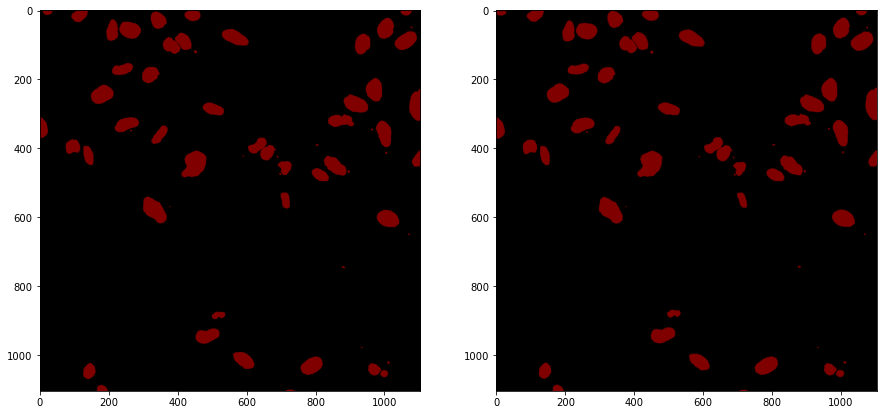

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(image1)
plt.subplot(122)
plt.imshow(image2)

#### Convert to boundary-labels and save

In [16]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))
filelist.remove('.ipynb_checkpoints')
image_names = [os.path.join('/home/jupyter/aitslab_images/raw_annotations/', f) for f in filelist]

In [17]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [18]:
labels_dir = '/home/jupyter/aitslab_images/boundary_labels/manually_annotated/'
for n,i in enumerate(images):

    # strip the first channel
    if len(i.shape) == 3:
        i = i[:,:,0]
    
    annot = skimage.morphology.label(i) # convert to annotation
    boundaries = skimage.segmentation.find_boundaries(annot) #extract boundaries
    
    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
    
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))

    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1
    label_binary[boundaries == 1, 2] = 1
    
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(labels_dir + filelist[n], label_binary)
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

#### Reshape to (520x696) and save

##### norm images

In [21]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))
filelist.remove('.ipynb_checkpoints')
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images/', f) for f in filelist]

In [22]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [23]:
#images_reshaped = list()
for n,i in enumerate(images):
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    skimage.io.imsave('/home/jupyter/aitslab_images/reshaped_images/' + filelist[n], i)
    #images_reshaped.append(i)
#images_reshaped = np.asarray(images_reshaped)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.018435013262477967, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppre

##### convert boundary lables into reshaped boundary labels 

In [24]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))
filelist.remove('.ipynb_checkpoints')
image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/manually_annotated/', f) for f in filelist]

In [26]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [27]:
#images_reshaped = list()
for n,i in enumerate(images):
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    skimage.io.imsave('/home/jupyter/aitslab_images/boundary_labels/reshaped_manually_annotated/' + filelist[n], i)
    #images_reshaped.append(i)
#images_reshaped = np.asarray(images_reshaped)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


### sinus-transformation

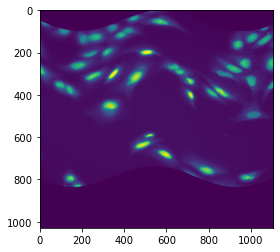

In [75]:
image = image1
rows, cols = image.shape[0], image.shape[1]

src_cols = np.linspace(0, cols, 20)
src_rows = np.linspace(0, rows, 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
dst_cols = src[:, 0]
dst_rows *= 1.5
dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T


tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

out_rows = image.shape[0] - 1.5 * 50
out_cols = cols
out = warp(image, tform, output_shape=(out_rows, out_cols))

fig, ax = plt.subplots()
ax.imshow(out)
#ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
ax.axis((0, out_cols, out_rows, 0))
plt.show()

#### Round 2 for images to predict on

In [12]:
filelist = ['MFGTMPcx7_170803210001_B18f27d0.png', 'MFGTMPcx7_170803210001_B19f26d0.png']

In [2]:
image_names = ['aitslab_images/raw_annotations/MFGTMPcx7_170803210001_B18f27d0.png','aitslab_images/raw_annotations/MFGTMPcx7_170803210001_B19f26d0.png']

In [8]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [10]:
from config import config_vars

In [11]:
config_vars['elastic_distortion'] = 12
config_vars['elastic_augmentations'] = 5
config_vars['elastic_points'] = 20

In [13]:
training_files = generate_augmented_examples(
        #tmp_partitions["training"], 
        filelist,
        config_vars["elastic_augmentations"], 
        config_vars["elastic_points"], 
        config_vars["elastic_distortion"],
        '/home/jupyter/aitslab_images/raw_annotations/',
        #config_vars["boundary_labels_dir"], 
        '/home/jupyter/aitslab_images/norm_images/'
        #config_vars["normalized_images_dir"]
    )

  0%|          | 0/2 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 50%|█████ 

#### convert to boundary label and save

In [33]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))
filelist = [f for f in filelist if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']
image_names = [os.path.join('/home/jupyter/aitslab_images/raw_annotations', f) for f in filelist]

In [35]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [36]:
labels_dir = '/home/jupyter/aitslab_images/boundary_labels/manually_annotated/'
for n,i in enumerate(images):

    # strip the first channel
    if len(i.shape) == 3:
        i = i[:,:,0]
    
    annot = skimage.morphology.label(i) # convert to annotation
    boundaries = skimage.segmentation.find_boundaries(annot) #extract boundaries
    
    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
    
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))

    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1
    label_binary[boundaries == 1, 2] = 1
    
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(labels_dir + filelist[n], label_binary)
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

#### reshape

##### norm images

In [41]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))

In [42]:
filelist = [f for f in filelist if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']

In [43]:
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images/', f) for f in filelist]

In [44]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [45]:
#images_reshaped = list()
for n,i in enumerate(images):
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    skimage.io.imsave('/home/jupyter/aitslab_images/reshaped_images/' + filelist[n], i)
    #images_reshaped.append(i)
#images_reshaped = np.asarray(images_reshaped)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


##### boundary labels

In [46]:
filelist = sorted(os.listdir('/home/jupyter/aitslab_images/raw_annotations'))

In [47]:
filelist = [f for f in filelist if f[0:31] == 'MFGTMPcx7_170803210001_B18f27d0' or f[0:31] == 'MFGTMPcx7_170803210001_B19f26d0']

In [48]:
image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/manually_annotated/', f) for f in filelist]

In [49]:
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

In [50]:
#images_reshaped = list()
for n,i in enumerate(images):
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    skimage.io.imsave('/home/jupyter/aitslab_images/boundary_labels/reshaped_manually_annotated/' + filelist[n], i)
    #images_reshaped.append(i)
#images_reshaped = np.asarray(images_reshaped)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
